# Modelling Facebook with random graphs

#### In this report, we will look at a sample of the social network Facebook, and attempt to model it using different models of random graphs. The models that will be used are the Erdős–Rényi, Watts-Strogatz, Barabási–Albert, and the Klemm-Eguíluz model.

Facebook is a social media giant, and a good representation of how social networks might be in reality. To model and study social networks, random graphs are often used in attempts to replicate the structure of a network. 

Data for a small sample of Facebook is available at the Stanford Large Database Collection (SNAP). Using this, we will analyse how accurately random graph models can model the sample. First of all, we will look at the sample of Facebook itself, by drawing a graph of the nodes and edges given the data from SNAP, and observing the features of the graph.

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import Counter

# Reading edges from file, and adding them
g = nx.Graph()
with open("facebook_combined.txt") as f:
    edges = f.read().split("\n")
    edges.pop()
    edges = [tuple(map(int, edge.split(" "))) for edge in edges]
g.add_edges_from(edges)

Now with this data, we will look at the characteristics of the graph, and in particular, the average clustering coefficient, and the degree distribution.

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910
Global clustering coefficient: 0.6055
Transitivity: 0.5192
Diameter: 8


C:\Users\kjkchang\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


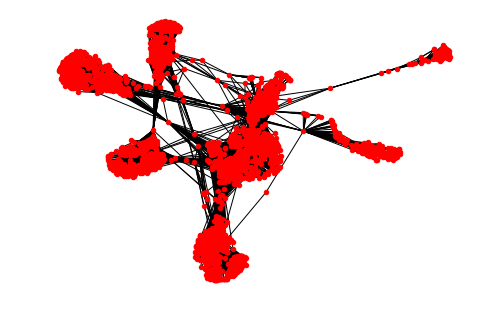

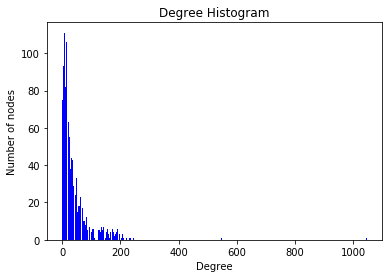

In [3]:
print(nx.info(g))
print(f"Global clustering coefficient: {np.round(nx.average_clustering(g), 4)}")
print(f"Transitivity: {np.round(nx.transitivity(g), 4)}")
print(f"Diameter: {np.round(nx.diameter(g), 4)}")
nx.draw(g, node_size = 20)
plt.show()
plt.clf()

degree_sequence = sorted([d for n, d in g.degree()], reverse=True)
countf = Counter(degree_sequence)

plt.bar(countf.keys(), countf.values(), width=0.80, color='b')
plt.title("Degree Histogram")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.show()


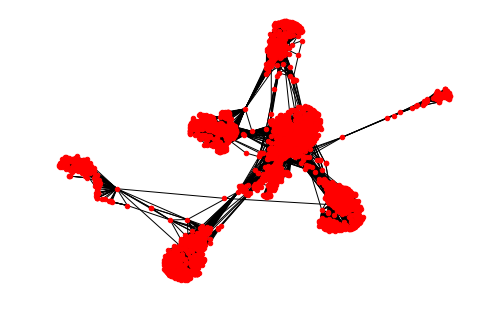

In [7]:
nx.draw(g, node_size=20)

Note that the degree distribution is highly skewed, roughly following a power law of $n = a \times k^b$, which would make it a scale free distribution. The average clustering coefficient is high as well, being around 0.6. The diameter (maximum minimum distance) of the graph is 8, which means that any two nodes can be connected in a maximum of 8 edges. Qualitatively, we can note that the network consists of obvious clusters of nodes which are highly connected within itself, and sparsely connected to other clusters.

Assuming that the degree distribution is scale free and thus follows a power law, we will use a linear regression model to estimate a function for the distribution. We therefore assume $n = ak^b$, where k is the degree of a node, and n is the number of nodes with that degree, and both $a$ and $b$ are constants. Thus we take log to base 10 on both sides, and perform linear regression on $log_{10} t$ and $log_{10} n$. The coefficient and vertical intercept are then found, which are equal to $b$, and $log_{10} a$ respectively. 

With these values, the estimated function is then plotted together with the actual degree distribution, with the red line representing the estimated function.

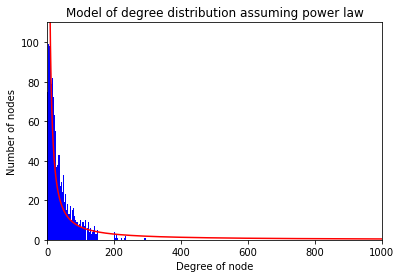

b = -1.1802
log10a = 3.1754


In [3]:
from sklearn import linear_model
regf = linear_model.LinearRegression()
yf = np.array(list(map(np.math.log10, countf.values()))).reshape(-1, 1)
xf = np.array(list(map(np.math.log10,[key for key in countf.keys()]))).reshape(-1,1)
regf.fit(xf, yf)

kf = [i for i in range(1, 1000)]
nf = [((i**regf.coef_[0][0])*(10**regf.intercept_[0])) for i in kf]
plt.title("Model of degree distribution assuming power law")
plt.xlabel("Degree of node")
plt.ylabel("Number of nodes")
plt.plot(kf, nf, color = 'r')
plt.axis([0, 1000, 0, 110])
plt.bar(countf.keys(), countf.values(), width=0.80, color='b')

plt.show()

print(f"b = {np.round(regf.coef_, 4)[0][0]}")
print(f"log10a = {np.round(regf.intercept_, 4)[0]}")

Now, we will try to create accurate replicas using different models of random graphs.

The first model we will look at is the Erdős–Rényi model. This model requires two parameters, $n$ for the number of nodes, and $p$ for the probability of an edge existing between any two nodes independently. The expected total number of edges is therefore $p \times {n \choose 2}$, as ${n \choose 2}$ is the total possible number of edges that can be formed.

Using this, we will create models where $n = 4039$ and $p = \frac{88234} {{n \times (n-1)} / 2}$, and observe the characteristics of the graph.

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88587
Average degree:  43.8658
Global clustering coefficient: 0.0108
Transitivity: 0.0108
Diameter: 4


C:\Users\kjkchang\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


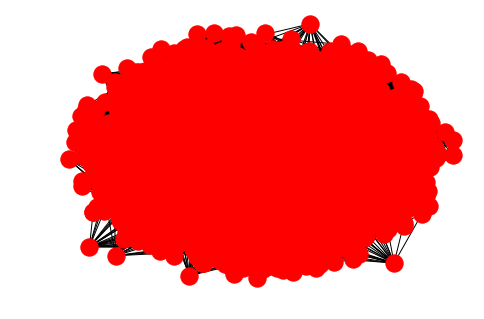

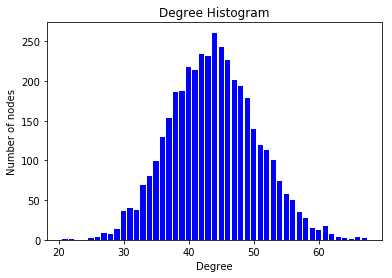

In [4]:
n = 4039
p = 88234 / (n * (n-1) / 2)

g = nx.erdos_renyi_graph(n, p)
print(nx.info(g))
print(f"Global clustering coefficient: {np.round(nx.average_clustering(g), 4)}")
print(f"Transitivity: {np.round(nx.transitivity(g), 4)}")
print(f"Diameter: {np.round(nx.diameter(g), 4)}")
nx.draw(g)
plt.show()
plt.clf()

degree_sequence = sorted([d for n, d in g.degree()], reverse=True)
count = Counter(degree_sequence)

plt.bar(count.keys(), count.values(), width=0.80, color='b')
plt.title("Degree Histogram")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.show()

The number of edges is close to the actual value of the sample, as expected. However, the average clustering coefficient is quite different, and the degree distribution is not skewed, but rather it has a pronounced peak in the middle. The diameter is also much shorter, at half of the value of the sample. As such, this is sufficient to determine that the model cannot accurately represent a social network such as Facebook.

We move on to the next model, which is the Watts-Strogatz model. This model requires 3 parameters,  𝑛  for the number of nodes,  𝑘 , an even number, for the mean degree, and a special parameter  𝛽  where  0<𝛽<1 . A graph of  𝑛  nodes is first created, with each node connected to  𝑘/2  nodes to their immediate left and right. Each edge in the graph is then rewired with probability  𝛽 , and this is done so without duplication or self-looping. 

In our model, we will use $n = 4039$, $k = \frac {88234 \cdot 2} {n} \approx 44$ (as $k$ has to be an even number). 

The average clustering coefficient, $C = \frac {3(k-2)} {4(k-1)} (1-\beta)^3$. As such, $\beta = 1 - (C \cdot \frac {4(k-1)} {3(k-2)})^{\frac{1}{3}}$.

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88858
Average degree:  44.0000
Global clustering coefficient: 0.6086
Transitivity: 0.6071
Diameter: 5


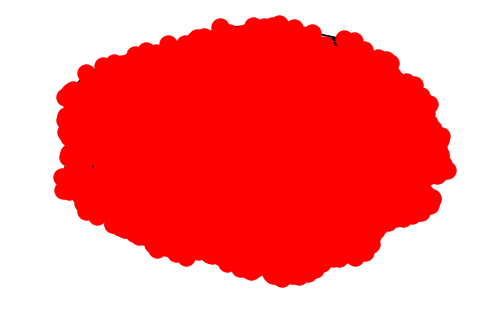

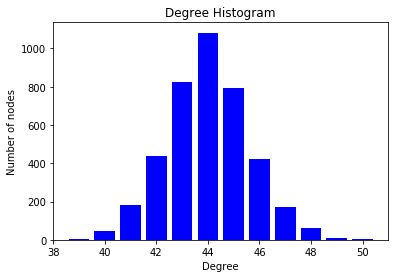

In [5]:
n = 4039
k = 44
beta = 1 - (0.6055 * (4 * (k-1)) / (3 * (k-2))) ** (1/3)

g = nx.watts_strogatz_graph(n, k, beta)
print(nx.info(g))
print(f"Global clustering coefficient: {np.round(nx.average_clustering(g), 4)}")
print(f"Transitivity: {np.round(nx.transitivity(g), 4)}")
print(f"Diameter: {np.round(nx.diameter(g), 4)}")
nx.draw(g)
plt.show()
plt.clf()

degree_sequence = sorted([d for n, d in g.degree()], reverse=True)
count = Counter(degree_sequence)

plt.bar(count.keys(), count.values(), width=0.80, color='b')
plt.title("Degree Histogram")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.show()

With the Watts-Strogatz Model, the clustering coefficient is now much higher, and hits 0.6 as expected. However, the degree distribution still peaks around the centre, and does not seem to follow a scale free distribution as shown by Facebook. As such, the model is not quite accurate as well.

The next model we will look at is the Barabási–Albert Model. This model uses two parameters, $n$ for the number of nodes, and $m$ for the number of edges per node. The model begins with $m$ nodes in an empty graph, and at each next step, a node is added, with m edges connected to other nodes. The probability of the new node being connected to a node is equal to the proportion of the degree of the node to the total degree of the graph.

For the models that we will draw, we will use $n = 4039$, and $m = \frac {88234} {n} \approx 22$ (As $m$ has to be an integer).

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88374
Average degree:  43.7603
Global clustering coefficient: 0.0379
Transitivity: 0.0361
Diameter: 4


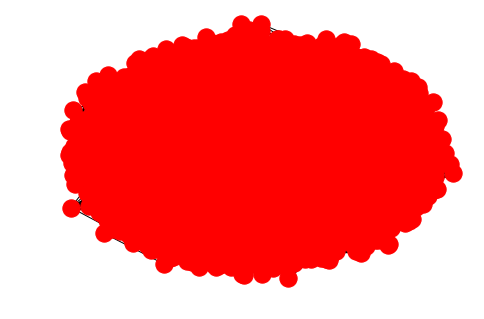

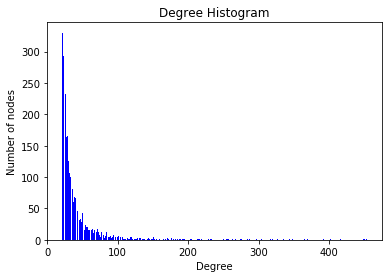

In [6]:
n = 4039
m = 22

g = nx.barabasi_albert_graph(4039, 22)
print(nx.info(g))
print(f"Global clustering coefficient: {np.round(nx.average_clustering(g), 4)}")
print(f"Transitivity: {np.round(nx.transitivity(g), 4)}")
print(f"Diameter: {np.round(nx.diameter(g), 4)}")
nx.draw(g)
plt.show()
plt.clf()

degree_sequence = sorted([d for n, d in g.degree()], reverse=True)
count = Counter(degree_sequence)

plt.bar(count.keys(), count.values(), width=0.80, color='b')
plt.title("Degree Histogram")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.show()

The degree histogram for the model shows that the distribution is scale free, but it is observed that the degree of nodes does not begin at the origin, instead the lowest value of the degree for the nodes is much higher, at around 20. This is due to the model requiring each node to have $m$ edges added when it is introduced into the network. the average clustering for the model is also much too low, as it is at 0.03, while the sample has an average clustering of 0.6. As such, this model is not entirely accurate as well. 

The last model we will be looking at is the Klemm-Eguíluz model. This model is a small-world and scale free model that is a crossover of a high clustering model and the Barabasi-Albert model. It begins with a connected graph of  𝑚  number of active nodes, and a new node is added in each time step. The new node has  𝑚  edges added to the  𝑚  active nodes, and each edge is decided, with probability  𝜇 , that the edge is rewired to a random node according to linear preferential attachment. The new node is then active, and a random node is deactivated, such that  𝑚  active nodes remain.¶ As such, the $\mu$ parameter determines the extent of crossover between the high clustering and the Barabasi-Albert model; when $\mu$ is 0, the model is essentially a high clustering network, and when $\mu$ is 1, the graph drawn is a Barabasi-Albert model.


For this model, we will use $n = 4039$, $m = \frac {888234} {n} \approx 22$. The value of $\mu$ will be determined by finding the value that best fits the average clustering coefficient of 0.6055.

In [3]:
# As this model is relatively new, there is no function already present in the library, thus we will define one

def klemm_eguiluz(n, m, mu):
    # initial condition of complete graphs with m nodes
    g = nx.complete_graph(m)
    # list used to represent whether or not a node is activated(1) or deactivated(0)
    activation = list(np.ones(m))
    
    for i in range(m, n):
        # generate list of edges which are to be randomly rewired
        mu_factor = np.random.ranf(m) < mu
        activated = [x for x in range(i) if activation[x] == 1]
        targets = set([activated[j] for j in range(m) if mu_factor[j] == 0])
        
        # Linear preferential attachment
        p_total = sum(map(g.degree, range(i)))
        p_dstr = [g.degree(node) / p_total for node in range(i)]
        
        while len(targets) < m:
            targets.add(np.random.choice(list(range(i)), p = p_dstr))
        g.add_edges_from(zip(np.full(m, i), list(targets)))
        
        # Activation and deactivation where p = a / k, and 1/a = sum of 1/k
        
        k = [g.degree(active)**-1 for active in activated]
        a = sum(k)
        p_deact = [l / a for l in k]
        deactivated = np.random.choice(activated, p = p_deact)
        activation[deactivated] = 0
        activation.append(1)
                
    return g

In [7]:
toc = time.time()
g = klemm_eguiluz(1000, 100, 0.1)
tic = time.time()
print(tic-toc)

2.4572508335113525


In [9]:
def test(mu):
    cc = []
    for i in range(10):
        g = klemm_eguiluz(4039, 22, mu)
        cc.append(nx.average_clustering(g))
    return sum(cc) / 10

tests = list(map(test, np.arange(0.08, 0.15, 0.01)))

closeness = list(map(abs,[test - 0.6055 for test in tests]))
closest = min(closeness)
index = closeness.index(closest)
mu = list(np.arange(0.08, 0.15, 0.01))[index]
print(f"The value of mu we will be using is: {mu}.")

The value of mu we will be using is: 0.09.


Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88605
Average degree:  43.8747
Global clustering coefficient: 0.6046
Transitivity: 0.2905
Diameter: 4


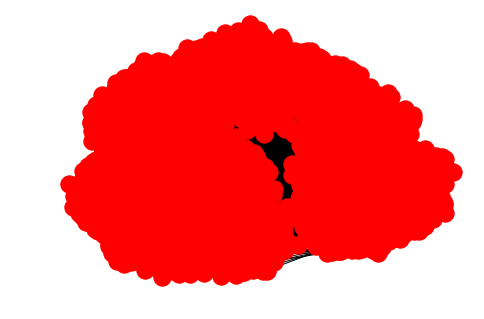

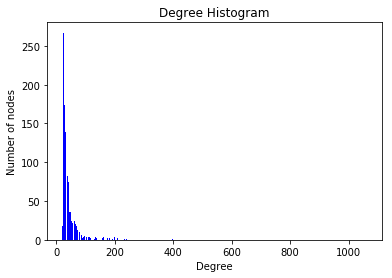

In [10]:
n = 4039
m = 22
mu = 0.09

g = klemm_eguiluz(n, m, mu)
print(nx.info(g))
print(f"Global clustering coefficient: {np.round(nx.average_clustering(g), 4)}")
print(f"Transitivity: {np.round(nx.transitivity(g), 4)}")
print(f"Diameter: {np.round(nx.diameter(g), 4)}")
nx.draw(g)
plt.show()
plt.clf()

degree_sequence = sorted([d for n, d in g.degree()], reverse=True)
count = Counter(degree_sequence)

plt.bar(count.keys(), count.values(), color='b')
plt.title("Degree Histogram")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.show()


The Klemm-Eguiluz model is able to give a graph with a high average clustering coefficient, and a skewed degree distribution as well. However, the degree distribution also begins at a much higher value around 20, instead of at 1. Regardless, given that the clustering coefficient is similar, we will now perform linear regression on the degree distribution to check how close it is to the estimated function for the degree distribution of the sample.

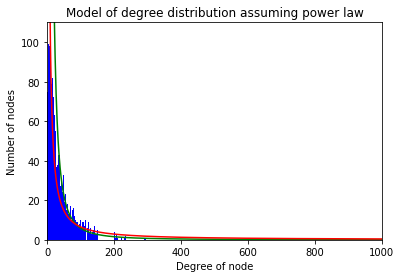

Sample: b = -1.1802
Sample: log10a = 3.1754
Model: b = -1.9263
Model: log10a = 4.6256


In [11]:
reg = linear_model.LinearRegression()
y = np.array(list(map(np.math.log10, count.values()))).reshape(-1, 1)
x = np.array(list(map(np.math.log10,[key for key in count.keys()]))).reshape(-1,1)
reg.fit(x, y)

k = [i for i in range(1, 1000)]
n = [((i**reg.coef_[0][0])*(10**reg.intercept_[0])) for i in k]
plt.title("Model of degree distribution assuming power law")
plt.xlabel("Degree of node")
plt.ylabel("Number of nodes")
plt.plot(k, n, color = 'g')
plt.axis([0, 1000, 0, 110])
plt.plot(kf, nf, color = 'r')
plt.bar(countf.keys(), countf.values(), width=0.80, color='b')

plt.show()

print(f"Sample: b = {np.round(regf.coef_, 4)[0][0]}")
print(f"Sample: log10a = {np.round(regf.intercept_, 4)[0]}")

print(f"Model: b = {np.round(reg.coef_, 4)[0][0]}")
print(f"Model: log10a = {np.round(reg.intercept_, 4)[0]}")

The values of the coefficient and the vertical intercept, while different, are relatively close. When plotted on the same graph, it can be seen that the two curves are quite similar, but the function estimated using the Klemm-Eguiluz model appears to be translated to the right compared to the sample function. As such, the model is able to model the clustering coefficient and degree distribution of Facebook better than the previous models, but this is not an accurate model.

The diameter of the graph is also too low, and it is not clearly grouped in clusters as the sample of Facebook networks depicted. Another point to note is the difference in transitivity as well. As the transitivity is lower by about 0.3, despite the similar value of average clustering, this suggests that the local clustering coefficient of higher degree nodes is lower. As such, the model has high degree nodes that are more likely to be connected to widely to different clusters, rather than connected densely within clusters. Overall, there are quite a few differences in the networks drawn that would make this model unrealistic as well.

By considering the average clustering, the diameter, and the degree distribution of the models and the sample networks, we can conclude that none of the models are able to model the social network sample particularly accurately. The Watt-Strogatz model is able to reach a high level of clustering, but does not give a skewed degree distribution. Barabasi-Albert graphs can give skewed degree distribution, but cannot reach the same level of clustering. The Klemm-Eguiluz model is able to do both, as a crossover of the models, but it cannot accurately represent the scale free degree distribution that is often present in social networks, and the diameter of the graphs are all not close to the value of 8 for the sample of Facebook. As such, it does not appear to be possible to model social networks accurately using any of these models.